Image Preprocessing 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import DenseNet121

In [2]:
# -----------------------------
# PARAMETERS
# -----------------------------
data_dir = "./dataset"   # Path to your dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
AUG_FACTOR = 10
EPOCHS = 15

In [3]:
# -----------------------------
# LOAD FILES & LABELS
# -----------------------------
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
class_to_index = {c: i for i, c in enumerate(classes)}

all_image_paths, all_labels = [], []
for cls in classes:
    paths = glob(os.path.join(data_dir, cls, "*"))
    all_image_paths.extend(paths)
    all_labels.extend([class_to_index[cls]] * len(paths))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Classes:", classes)
print("Original dataset size:", len(all_image_paths))

Classes: ['normal', 'osteoporosis']
Original dataset size: 372


In [5]:
# -----------------------------
# NORMALIZATION FUNCTION (Grayscale → RGB)
# -----------------------------
def normalize_image_rgb(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)  # grayscale
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.tile(img, [1, 1, 3])  # convert to RGB
    return img, label

# -----------------------------
# STRONG AUGMENTATION FUNCTION
# -----------------------------
def augment_image(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    img = tf.image.rot90(img, k=k)
    return img, label




In [6]:
# -----------------------------
# BUILD DATASET
# -----------------------------
dataset = tf.data.Dataset.from_tensor_slices((all_image_paths, all_labels))
dataset = dataset.map(normalize_image_rgb, num_parallel_calls=AUTOTUNE)

In [7]:
# -----------------------------
# SPLIT TRAIN / VAL / TEST
# -----------------------------
dataset_size = len(all_image_paths)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)

dataset = dataset.shuffle(dataset_size, reshuffle_each_iteration=False)
train_ds = dataset.take(train_size)
val_test_ds = dataset.skip(train_size)
val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

print("Train size:", sum(1 for _ in train_ds))
print("Val size  :", sum(1 for _ in val_ds))
print("Test size :", sum(1 for _ in test_ds))

Train size: 223
Val size  : 74
Test size : 75


In [8]:
# -----------------------------
# AUGMENT TRAINING DATA
# -----------------------------
train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE).repeat(AUG_FACTOR)
train_ds = train_ds.shuffle(buffer_size=train_size * AUG_FACTOR)

# -----------------------------
# BATCH & PREFETCH
# -----------------------------
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [9]:
# -----------------------------
# MODEL WITH DenseNet121
# -----------------------------
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
base_model.trainable = True  # fine-tune entire base

# ADD CUSTOM CLASSIFIER
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # binary classification

model = models.Model(inputs=base_model.input, outputs=outputs)

# -----------------------------
# COMPILE MODEL
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,304,257 (27.86 MB)

 Trainable params: 7,218,561 (27.54 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [10]:
# -----------------------------
# CALLBACKS
# -----------------------------
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# -----------------------------
# TRAIN MODEL
# -----------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1449s 10s/step - accuracy: 0.7520 - loss: 0.5298 - val_accuracy: 0.7973 - val_loss: 0.4593 - learning_rate: 1.0000e-04
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 2004s 14s/step - accuracy: 0.8354 - loss: 0.3795 - val_accuracy: 0.7162 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 2022s 14s/step - accuracy: 0.8744 - loss: 0.2966 - val_accuracy: 0.8243 - val_loss: 0.4664 - learning_rate: 1.0000e-04
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 2081s 15s/step - accuracy: 0.8865 - loss: 0.2801 - val_accuracy: 0.7973 - val_loss: 0.7577 - learning_rate: 1.0000e-04
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1725s 12s/step - accuracy: 0.9368 - loss: 0.1673 - val_accuracy: 0.8108 - val_loss: 0.6163 - learning_rate: 5.0000e-05
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1778s 12s/step - accuracy: 0.9395 - loss: 0.1617 - val_accuracy: 0.7568 - val_loss: 0.6953 - learning_rate: 5.0000e-05
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 1904s 

In [12]:
def evaluate_model(model, dataset, split_name="Dataset"):
    classes = ["normal", "osteoporosis"]
    y_true, y_pred = [], []

    for imgs, lbls in dataset:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(lbls.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = np.mean(y_true == y_pred)
    print(f"\n{split_name} Accuracy: {acc*100:.2f}%\n")

    print(f"{split_name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()



Train Accuracy: 90.72%

Train Classification Report:
              precision    recall  f1-score   support

      normal       0.94      0.87      0.91      1150
osteoporosis       0.87      0.94      0.91      1080

    accuracy                           0.91      2230
   macro avg       0.91      0.91      0.91      2230
weighted avg       0.91      0.91      0.91      2230



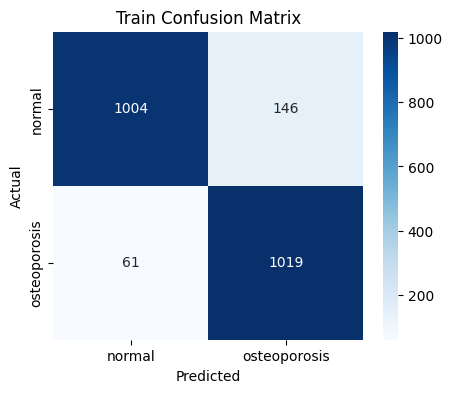


Validation Accuracy: 82.43%

Validation Classification Report:
              precision    recall  f1-score   support

      normal       0.82      0.84      0.83        38
osteoporosis       0.83      0.81      0.82        36

    accuracy                           0.82        74
   macro avg       0.82      0.82      0.82        74
weighted avg       0.82      0.82      0.82        74



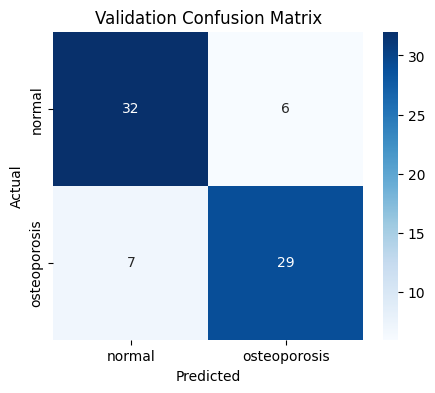


Test Accuracy: 72.00%

Test Classification Report:
              precision    recall  f1-score   support

      normal       0.66      0.76      0.70        33
osteoporosis       0.78      0.69      0.73        42

    accuracy                           0.72        75
   macro avg       0.72      0.72      0.72        75
weighted avg       0.73      0.72      0.72        75



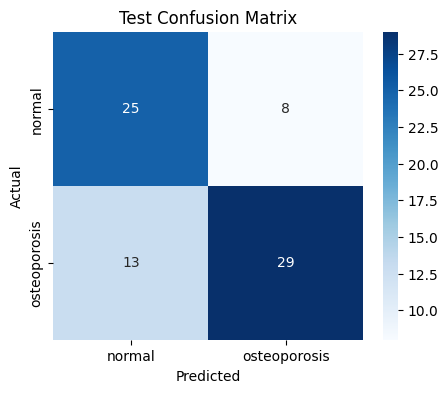

In [13]:
# =========================
# Run evaluation
# =========================
evaluate_model(model, train_ds, split_name="Train")
evaluate_model(model, val_ds, split_name="Validation")
evaluate_model(model, test_ds, split_name="Test")